# Sparse Gaussian process regression

Implementation of Bayesian sparse Gaussian process regression (Rossi et al., 2021).

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [2]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import blackjax
import jaxkern as jk

import numpyro as npr
import numpyro.distributions as dist
import numpyro.distributions.transforms as nprb

import sys

from blackjax import normal_random_walk, elliptical_slice
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

from bamojax.base import Model
from bamojax.samplers import gibbs_sampler
from bamojax.more_distributions import GaussianProcessFactory, Zero
from bamojax.inference import SMCInference

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Numpyro version:      ', npr.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.11.13 | packaged by conda-forge | (main, Jun  4 2025, 14:48:23) [GCC 13.3.0]
Jax version:           0.7.2
BlackJax version:      1.2.5
Numpyro version:       0.19.0
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


## Data generation

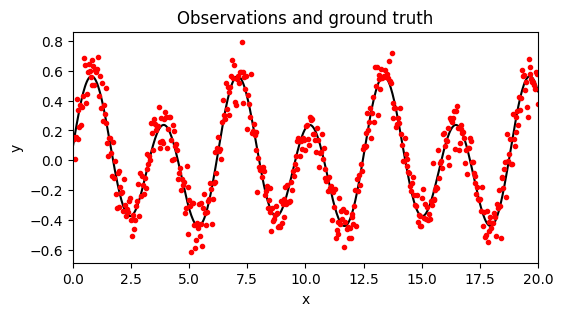

In [3]:
key = jrnd.PRNGKey(42)
key, subkey = jrnd.split(key)

sigma = 0.1
n = 500
x = jnp.linspace(0, 20, n)[:, jnp.newaxis]

f_true = 0.4*jnp.sin(2*x) + 0.1*jnp.cos(x-0.4) + 0.1*jnp.sin(x)
y = f_true.squeeze() + sigma*jrnd.normal(subkey, shape=(n,))

plt.figure(figsize=(6, 3))
plt.plot(x, f_true, color='k')
plt.plot(x, y, 'r.')
plt.xlim([0., 20.])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Observations and ground truth');

Create a bijector for a transformed distribution, as the `OrderedTransform` from `numpyro` does not seem to work.

In [8]:
def AscendingDistribution(min_u, max_u, num_el):
    r""" Creates a distribution of a sorted array of continuous values in [min_u, max_u].

    To ensure gradient-based methods can work on the model, all transformations must be bijectors.
    A generic sort() does not meet this condition, as it is not invertible. By using the tfb 
    bijector Ascending() in combination with scaling and deriving the expected maximum value of 
    dx.Transformed(Uniform, Ascending()), we can construct, in expectation, the desired random 
    variable. Note that individual draws main contain values that exceed max_u. 

    Args:
        min_u, max_u: The desired range.
        num_el: The length of the desired variate.
    Returns:
        A distribution over arrays of length `num_el`, with values in ascending order.

    
    """

    R = 0.5 + (num_el-1)*(jnp.exp(1) - 1)
    base_distribution = dist.Uniform(low=jnp.zeros(num_el), high=jnp.ones(num_el))

    bijector = nprb.ComposeTransform([
        nprb.AffineTransform(loc=min_u, scale=(max_u - min_u) / R),
        nprb.OrderedTransform()               
    ])

    return dist.TransformedDistribution(base_distribution, bijector)

#
m = 10
tmp = AscendingDistribution(0.0, 20.0, m)
draw = tmp.sample(key=jrnd.PRNGKey(0))

assert jnp.all(jnp.diff(draw) > 0), 'Output is not sorted!'

print('draw:', draw)
print('diff:', jnp.diff(draw))

draw: [ 0.52423334  1.83546896  5.18671516  7.24057508  9.1884928  10.74838537
 13.77127471 15.98009142 17.93185297 19.20322865]
diff: [1.31123562 3.3512462  2.05385991 1.94791772 1.55989257 3.02288934
 2.20881671 1.95176155 1.27137568]


Set up the BaMoJax implementation:

In [ ]:
def FITC_link_fn(x, z, u, scale, **hyperparameters):
    r""" The FITC sparse GP interpretation.

    In FITC, the actual f(x_i) are assumed to be independent given u. We then have

    y_i ~ N(mu_i, sigma^2_i), with

    mu_i = K(x_i, z) K(z,z)^-1 u  

    and
    
    sigma^2_i K(x_i, x_i) - Kx_i, z) K(z,z)^-1 K(Z, x_i)
    
    """

    cov_params = dict(**hyperparameters)
    tau = hyperparameters['variance']
    K_xz = cov_fn(cov_params, x, z)
    K_zz = cov_fn(cov_params, z, z)
    mean = jnp.dot(K_xz, jnp.linalg.solve(K_zz, u))
    fitc_cov = tau*jnp.ones(n,) - jnp.diag(jnp.dot(K_xz, jnp.linalg.solve(K_zz, K_xz.T)))

    return dict(loc=mean, scale=fitc_cov + scale)

#

cov_fn = jk.RBF().cross_covariance  # GP covariance function
m = 10  # number of inducing pts


BSGP = Model('Bayesian Sparse Gaussian process', verbose=True)
lengthscale = BSGP.add_node(name='lengthscale', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))
variance = BSGP.add_node(name='variance', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))
obs_noise = BSGP.add_node(name='obs_noise', distribution=dist.TransformedDistribution(dist.Normal(loc=0., scale=1.), nprb.ExpTransform()))

x_node = BSGP.add_node(name='x', observations=x) 
# We can try different priors on the locations of the inducing points. 
z_node = BSGP.add_node(name='z', distribution=dist.Uniform(low=0*jnp.ones(m, ), high=20*jnp.ones(m, )))
# z_node = BSGP.add_node(name='z', distribution=AscendingDistribution(min_u=0.0, max_u=20.0, num_el=m))
u_node = BSGP.add_node(name='u', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=cov_fn), 
                       parents=dict(input=z_node, 
                                    lengthscale=lengthscale, 
                                    variance=variance))
y_node = BSGP.add_node(name='y', 
                       distribution=dist.Normal, 
                       observations=y, 
                       parents=dict(x=x_node, 
                                    z=z_node,
                                    u=u_node,                                    
                                    scale=obs_noise, 
                                    lengthscale=lengthscale,
                                    variance=variance), 
                       link_fn=FITC_link_fn)

BSGP.print_gibbs()

Adding node (lengthscale)
Adding node (variance)
Adding node (obs_noise)
Adding node (x)
Adding node (z)
Adding node (u)
Add edge (z) -> (u)
Add edge (lengthscale) -> (u)
Add edge (variance) -> (u)
Adding node (y)
Add edge (x) -> (y)
Add edge (z) -> (y)
Add edge (u) -> (y)
Add edge (obs_noise) -> (y)
Add edge (lengthscale) -> (y)
Add edge (variance) -> (y)
Gibbs structure:
z                   : p(y | variance, lengthscale, x, u, obs_noise, z) p(u | variance, z, lengthscale) p(z)
lengthscale         : p(y | variance, lengthscale, x, u, obs_noise, z) p(u | lengthscale, variance, z) p(lengthscale)
variance            : p(y | lengthscale, variance, x, u, obs_noise, z) p(u | variance, lengthscale, z) p(variance)
u                   : p(y | variance, lengthscale, x, obs_noise, z, u) p(u | variance, z, lengthscale)
obs_noise           : p(y | variance, lengthscale, x, u, z, obs_noise) p(obs_noise)


## SMC for a Bayesian sparse GP

In [ ]:
%%time

num_mcmc_steps = 40
num_particles = 1_000

step_fns = dict(lengthscale=normal_random_walk,
                variance=normal_random_walk,
                obs_noise=normal_random_walk,
                z=normal_random_walk,
                u=elliptical_slice)

step_fn_params = dict(lengthscale=dict(sigma=0.2),
                      variance=dict(sigma=0.1),
                      obs_noise=dict(sigma=0.01),
                      z=dict(sigma=0.01*jnp.eye(m)),
                      u=dict(implied_mvn_prior=True, name='elliptical_slice'))

gibbs = gibbs_sampler(BSGP, step_fns=step_fns, step_fn_params=step_fn_params)

key, subkey = jrnd.split(key)

engine = SMCInference(model=BSGP, mcmc_kernel=gibbs, num_particles=num_particles, num_mutations=num_mcmc_steps, return_diagnostics=True)
result = engine.run(subkey)

final_info = result['final_info']
lml = result['lml']
n_iter = result['n_iter']
final_state = result['final_state']

for node in ['lengthscale', 'variance', 'obs_noise', 'z']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

print('log marginal likelhood:', lml)
print('number of SMC iterations:', n_iter)

: 

: 

There's something strange with the `numpyro` approach to the GP, as the computation time in insane (was 6 minutes before). TODO!

We also see a `nan` log marginal likelihood, suggesting memory trouble (which is not surprising given the huge number of adaptive iterations).

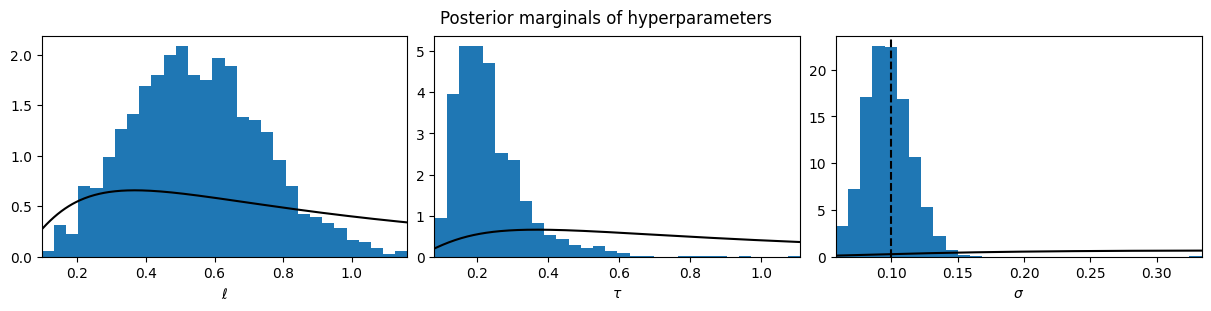

In [ ]:
symbols = [r'\ell', r'\tau', r'\sigma']
names = ['lengthscale', 'variance', 'obs_noise']
_, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 3), constrained_layout=True)
res = 300

for name, ax, symbol in zip(names, axes, symbols):
    vals = final_state.particles[name].flatten()
    ax.hist(vals, bins=30, density=True)
    min_val, max_val = jnp.min(vals), jnp.max(vals)
    xrange = jnp.linspace(min_val, max_val, num=res)
    prior_pdf = jnp.exp(BSGP.nodes[name].get_distribution().log_prob(xrange))
    ax.plot(xrange, prior_pdf, color='k')
    ax.set_xlim([min_val, max_val])
    ax.set_xlabel(fr'${symbol}$')

axes[2].axvline(x=sigma, color='k', ls='--')

plt.suptitle('Posterior marginals of hyperparameters');

Sample from $p(f^*\mid x^*, Z, y, u, \theta)$.

In [ ]:
def fitc_wrapper(k, particle):
    gauss_params = FITC_link_fn(x, particle['z'].flatten(), particle['u'].flatten(), scale=0.0, lengthscale=particle['lengthscale'], variance=particle['variance'])
    return dist.Normal(**gauss_params).sample(key=k)

#
key, subkey = jrnd.split(key)
keys = jrnd.split(subkey, num_particles)
f_pred = jax.vmap(fitc_wrapper)(keys, final_state.particles)

Visualize approximation (note: we only need to sort when we use $z_i \sim \mathcal{U}(0, 20)$, that is the point of the `AscendingDistribution`):

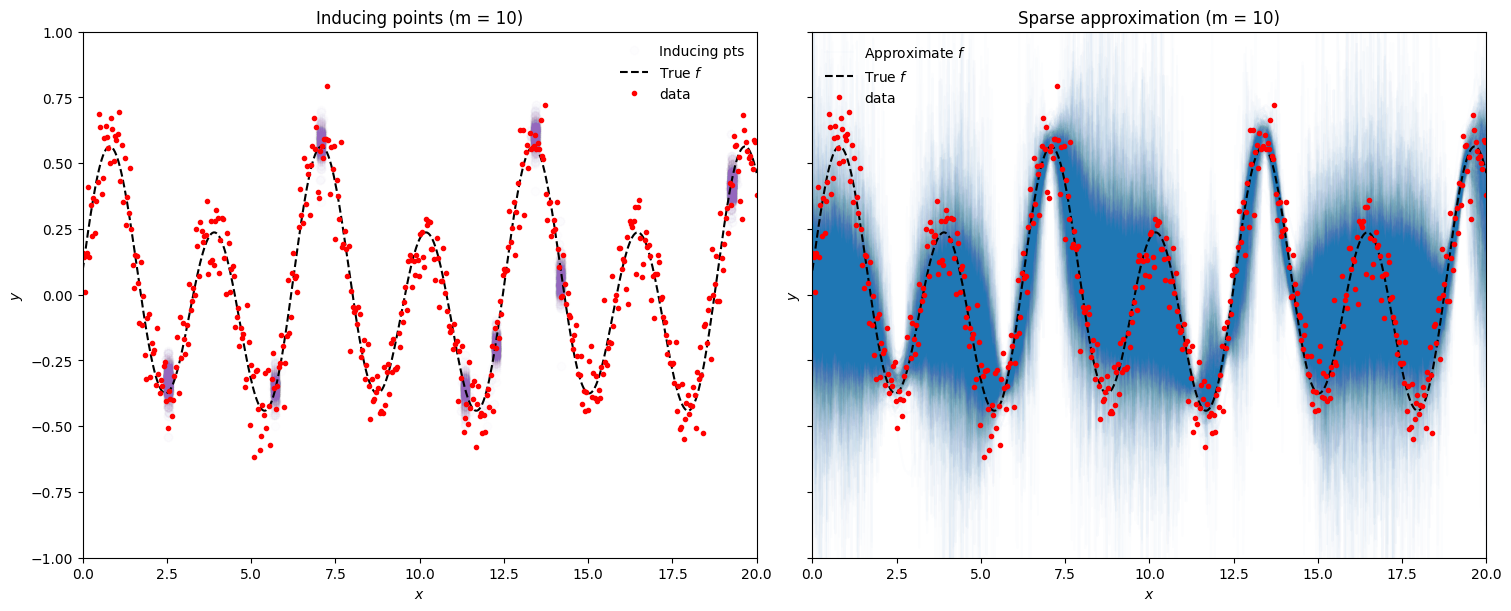

In [ ]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True, constrained_layout=True)

num_show = 500
key, subkey = jrnd.split(key)
inds = jrnd.randint(subkey, shape=(num_show,), minval=0, maxval=num_particles)

for i, ix in enumerate(inds):
    
    z_ix = final_state.particles['z'][ix].flatten()
    u_ix = final_state.particles['u'][ix].flatten()

    sort_ix = jnp.argsort(z_ix)
    z_ix = z_ix[sort_ix]
    u_ix = u_iz[sort_ix]
    if i == 0:
        axes[0].plot(z_ix, u_ix, ls='None', marker='o', alpha=0.01, color='tab:purple', label='Inducing pts')
        axes[1].plot(x.flatten(), f_pred[ix, :].flatten(), alpha=0.01, color='tab:blue', label=r'Approximate $f$')
    else:
        axes[0].plot(z_ix, u_ix, ls='None', marker='o', alpha=0.01, color='tab:purple')
        axes[1].plot(x.flatten(), f_pred[ix, :].flatten(), alpha=0.01, color='tab:blue')
    
    
for ax in axes:
    ax.plot(x, f_true, color='k', ls='--', label=r'True $f$')
    ax.plot(x, y, 'r.', label='data')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_xlim([0.0, 20.0])
    ax.set_ylim([-1, 1])
    ax.legend(frameon=False)

axes[0].set_title(f'Inducing points (m = {m})')
axes[1].set_title(f'Sparse approximation (m = {m})');

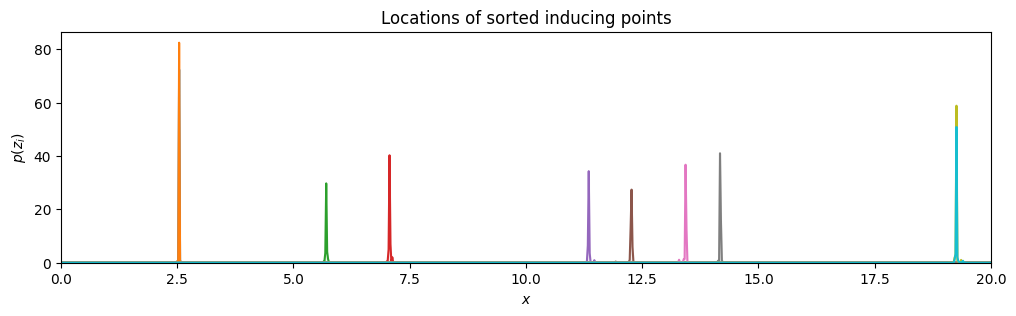

In [ ]:
from jax.scipy.stats import gaussian_kde

zrange = jnp.linspace(0, 20, num=1000)

plt.figure(figsize=(12, 3))
ax = plt.gca()
for i in range(m):
    zi_particles = final_state.particles['z'][:,i]
    pdf = gaussian_kde(zi_particles)
    pdf_zi = pdf(zrange)
    color = ax._get_lines.get_next_color()
    
    ax.plot(zrange, pdf_zi, color=color)
    ax.fill_between(zrange, pdf_zi, jnp.zeros_like(pdf_zi), color=color, alpha=0.1)
ax.set_xlim([0., 20.])
ax.set_ylim(bottom=0)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$p(z_i)$')
ax.set_title('Locations of sorted inducing points');